# Description of Eco-Driving Environment .ipynb File

This file contains a simple implementation of the Eco-Driving OpenAI Gym environment, using Python and the PyTorch library. **The environment simulates a car driving scenario on a straight, flat road with no air friction or inner cost.** The traction force is assumed to be fully converted into acceleration of the vehicle, and the car's speed can be controlled through acceleration and deacceleration actions.

The reward system for this environment considers the traction work done and the speed deviation from a safety speed. **The PyTorch library is used to build a DQN (Deep Q-Network) model, which is then used to create an agent that interacts with the environment.**

The EcoDrivingEnv class is defined and initialized in the notebook, providing a basic structure for the environment. A test environment is created and run with random actions to ensure that the environment is working as expected.

The DQN model is then built using PyTorch to create an agent that interacts with the environment. The agent uses the DQN model to predict the best action to take in each state of the environment.

Overall, this notebook is a simple implementation of an Eco-Driving OpenAI Gym environment, using PyTorch and a DQN model.This file was inspired by a Github repository https://github.com/indigoLovee/DQN, which provided guidance on implementing DQN model with Pytorch.

# **0.Install Dependencies**

---



In [ ]:
# !pip install gym
# !pip install numpy==1.20
# !pip install tensorflow==2.5.0
# !pip install keras
# !pip install keras-rl2
# !pip install torch


# **1. Test a Simple Eco-Driving Scenario**


---




> **import packages**

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

> **This block is EcoDrivingEnv**

In [3]:
import gym
from gym import spaces
import numpy as np
import random

class EcoDrivingEnv(gym.Env):
    def __init__(self):
        self.safe_speed_limit = 20 # m/s, equal 72kph
        self.time_step = 0.1 # seconds
        self.mass = 1000 # kg
        self.gravity = 9.81 # m/s^2
        self.MAX_SPEED = 40 # m/s, equal 144kph
        self.friction_coefficient = 0.8
        self.position = 0
        self.speed = 20
        self.work = 0
        self.steps = 0
        self.total_reward = 0
        self.distance = 1000 # m
        self.max_steps = 5000 # 5000 steps, 500s
        self.max_acceleration = 1 # m/s^2

        # Action Space deaccelerate, no action, accelerate
        self.action_space = spaces.Discrete(3) 

        # Observation space [position, speed]
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([np.inf, np.inf]), dtype=np.float32)

        print("Successfully Initialize EcoDrivingEnv.......")

    def reset(self):
        self.position = 0
        self.speed = 0
        self.work = 0
        self.steps = 0
        self.total_reward = 0
        return np.array([self.position, self.speed], dtype=np.float32)

    def step(self, action):
        # Apply action
        if action == 0:
            acceleration = -self.max_acceleration # -1
        elif action == 1:
            acceleration = 0
        elif action == 2:
            acceleration = self.max_acceleration # +1
        else:
            acceleration = 0


        # Calculate new speed and position
        new_speed = self.speed + acceleration * self.time_step # vt = v0 + a * dt
        new_speed = np.clip(new_speed, 0, self.MAX_SPEED) # speed no bigger than max speed

        # xt = x0 + vt + 0.5 * a * t^2
        new_position = self.position + self.speed * self.time_step + 0.5 * acceleration * self.time_step ** 2

        # Calculate work of friction force
        friction_force = self.friction_coefficient * self.mass * acceleration # F = 0.8 * m * a
        self.work += friction_force * (new_position - self.position) # W = F * dx

        # Calculate speed deviation from safe speed limit
        speed_deviation = abs(new_speed - self.safe_speed_limit)

        # Calculate Reward
        # reward = - 0.0002 * self.work  - 0.9998 * speed_deviation
        reward = - 0.001 * self.work / (self.work + speed_deviation) - 0.999 * speed_deviation / (self.work + speed_deviation)
        # print('Work: {}\t  speed_deviation:{}'.format(0.0005 * self.work, 0.9995 * speed_deviation))

        # Update state
        self.position = new_position
        self.speed = new_speed
        self.steps += 1

        # Check if episode is done, distance or steps satisfied
        done = False
        if self.position >= self.distance or self.steps >= self.max_steps:
          done = True

        # Update info dictionary with additional information
        self.state = np.array([self.position, self.speed], dtype=np.float32)
        info = {'friction_work': self.work, 'speed_deviation': speed_deviation}

        # Return step information
        return self.state, reward, done, info


    def render(self):
        print(f"Position: {self.position:.2f}m, Speed: {self.speed:.2f}m/s, Work: {self.work:.2f}J, Steps: {self.steps}")
        pass

> **Instantiate  an Eco-Drving Environment**

In [5]:
env = EcoDrivingEnv()

Successfully Initialize EcoDrivingEnv.......


> **Test Environment with Random Action**

In [6]:
# env.action_space.sample()
# env.observation_space.sample()

In [7]:
episode = 10

flag = 0
position = []
speed = []

for episode in range(1, episode+1):
  state = env.reset()
  done = False
  score = 0
  
  while not done:
    action = random.choice([0, 1, 2])
    n_state, reward, done, info = env.step(action)
    score += reward

    if not flag:
      position.append(n_state[0])
      speed.append(n_state[1])
  flag = 1

  print('===== Episode:{} Score:{} ====='.format(episode, int(score)))


===== Episode:1 Score:-137 =====
===== Episode:2 Score:-192 =====
===== Episode:3 Score:-132 =====
===== Episode:4 Score:-157 =====
===== Episode:5 Score:-254 =====
===== Episode:6 Score:-132 =====
===== Episode:7 Score:-292 =====
===== Episode:8 Score:-83 =====
===== Episode:9 Score:-188 =====
===== Episode:10 Score:-107 =====


# **2. Code of DQN Model**

---



In [30]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np



---
> **Buffer.py**


In [25]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size, batch_size):
        self.mem_size = max_size
        self.batch_size = batch_size
        self.mem_cnt = 0

        self.state_memory = np.zeros((self.mem_size, state_dim))
        self.action_memory = np.zeros((self.mem_size, ))
        self.reward_memory = np.zeros((self.mem_size, ))
        self.next_state_memory = np.zeros((self.mem_size, state_dim))
        self.terminal_memory = np.zeros((self.mem_size, ), dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        mem_idx = self.mem_cnt % self.mem_size

        self.state_memory[mem_idx] = state
        self.action_memory[mem_idx] = action
        self.reward_memory[mem_idx] = reward
        self.next_state_memory[mem_idx] = state_
        self.terminal_memory[mem_idx] = done

        self.mem_cnt += 1

    def sample_buffer(self):
        mem_len = min(self.mem_size, self.mem_cnt)

        batch = np.random.choice(mem_len, self.batch_size, replace=True)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.next_state_memory[batch]
        terminals = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminals

    def ready(self):
        return self.mem_cnt > self.batch_size



---
> **DQN.py**


In [26]:
# from buffer import ReplayBuffer

device = T.device("cuda:0" if T.cuda.is_available() else "cpu")


class DeepQNetwork(nn.Module):
    def __init__(self, alpha, state_dim, action_dim, fc1_dim, fc2_dim):
        super(DeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, fc1_dim)
        self.fc2 = nn.Linear(fc1_dim, fc2_dim)
        self.q = nn.Linear(fc2_dim, action_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)

    def forward(self, state):
        x = T.relu(self.fc1(state))
        x = T.relu(self.fc2(x))

        q = self.q(x)

        return q

    def save_checkpoint(self, checkpoint_file):
        T.save(self.state_dict(), checkpoint_file, _use_new_zipfile_serialization=False)

    def load_checkpoint(self, checkpoint_file):
        self.load_state_dict(T.load(checkpoint_file))


class DQN:
    def __init__(self, alpha, state_dim, action_dim, fc1_dim, fc2_dim, ckpt_dir,
                 gamma=0.99, tau=0.005, epsilon=1.0, eps_end=0.01, eps_dec=5e-4,
                 max_size=1000000, batch_size=256):
        self.tau = tau
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.batch_size = batch_size
        self.action_space = [i for i in range(action_dim)]
        self.checkpoint_dir = ckpt_dir

        self.q_eval = DeepQNetwork(alpha=alpha, state_dim=state_dim, action_dim=action_dim,
                                   fc1_dim=fc1_dim, fc2_dim=fc2_dim)
        self.q_target = DeepQNetwork(alpha=alpha, state_dim=state_dim, action_dim=action_dim,
                                     fc1_dim=fc1_dim, fc2_dim=fc2_dim)

        self.memory = ReplayBuffer(state_dim=state_dim, action_dim=action_dim,
                                   max_size=max_size, batch_size=batch_size)

        self.update_network_parameters(tau=1.0)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        for q_target_params, q_eval_params in zip(self.q_target.parameters(), self.q_eval.parameters()):
            q_target_params.data.copy_(tau * q_eval_params + (1 - tau) * q_target_params)

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def choose_action(self, observation, isTrain=True):
        state = T.tensor([observation], dtype=T.float).to(device)
        actions = self.q_eval.forward(state)
        action = T.argmax(actions).item()

        if (np.random.random() < self.epsilon) and isTrain:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if not self.memory.ready():
            return

        states, actions, rewards, next_states, terminals = self.memory.sample_buffer()
        batch_idx = np.arange(self.batch_size)

        states_tensor = T.tensor(states, dtype=T.float).to(device)
        rewards_tensor = T.tensor(rewards, dtype=T.float).to(device)
        next_states_tensor = T.tensor(next_states, dtype=T.float).to(device)
        terminals_tensor = T.tensor(terminals).to(device)

        with T.no_grad():
            q_ = self.q_target.forward(next_states_tensor)
            q_[terminals_tensor] = 0.0
            target = rewards_tensor + self.gamma * T.max(q_, dim=-1)[0]
        q = self.q_eval.forward(states_tensor)[batch_idx, actions]

        loss = F.mse_loss(q, target.detach())
        self.q_eval.optimizer.zero_grad()
        loss.backward()
        self.q_eval.optimizer.step()

        self.update_network_parameters()
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def save_models(self, episode):
        self.q_eval.save_checkpoint(self.checkpoint_dir + 'Q_eval/DQN_q_eval_{}.pth'.format(episode))
        print('Saving Q_eval network successfully!')
        self.q_target.save_checkpoint(self.checkpoint_dir + 'Q_target/DQN_Q_target_{}.pth'.format(episode))
        print('Saving Q_target network successfully!')

    def load_models(self, episode):
        self.q_eval.load_checkpoint(self.checkpoint_dir + 'Q_eval/DQN_q_eval_{}.pth'.format(episode))
        print('Loading Q_eval network successfully!')
        self.q_target.load_checkpoint(self.checkpoint_dir + 'Q_target/DQN_Q_target_{}.pth'.format(episode))
        print('Loading Q_target network successfully!')



---
> **utils.py**


In [27]:
import os
import matplotlib.pyplot as plt


def plot_learning_curve(episodes, records, title, ylabel, figure_file):
    plt.figure()
    plt.plot(episodes, records, linestyle='-', color='r')
    plt.title(title)
    plt.xlabel('episode')
    plt.ylabel(ylabel)

    plt.show()
    plt.savefig(figure_file)


def create_directory(path: str, sub_dirs: list):
    for sub_dir in sub_dirs:
        if os.path.exists(path + sub_dir):
            print(path + sub_dir + ' is already exist!')
        else:
            os.makedirs(path + sub_dir, exist_ok=True)
            print(path + sub_dir + ' create successfully!')


def save_best_profile(actions, states, episode):
    best_action = np.argmax(actions)
    best_state = np.argmax(states)
    np.savez(f'best_profile_episode_{episode}.npz', best_action=best_action, best_state=best_state)


def visualize_profile(rewards, states):
    # create x-axis (episode) values
    x = np.arange(1, len(rewards) + 1)

    # create subplots with shared x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(15, 4))

    # plot rewards
    ax1.plot(x, rewards, color='r', label='Rewards')
    ax1.set_ylabel('Rewards')

    # plot Position
    ax2.plot(x, states[:,0],  color='g', label='Position')
    ax2.set_ylabel('Position')
    ax2.legend()

    # plot Speed
    ax3.plot(x, states[:,1],  color='b', label='Speed')
    ax3.set_ylabel('Speed')
    ax3.legend()

    # add x-axis label
    plt.xlabel('Episode')

    # show the chart
    plt.show()

Successfully Initialize EcoDrivingEnv.......
./checkpoints/DQN/Q_eval is already exist!
./checkpoints/DQN/Q_target is already exist!


C:\Users\1\AppData\Local\Temp\ipykernel_8740\3575947009.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros((self.mem_size, ), dtype=np.bool)


EP: 1	 reward: -91.83	 avg_reward: -91.83	 epsilon: 0.1215
EP: 2	 reward: -5.091	 avg_reward: -48.46	 epsilon: 0.05
EP: 3	 reward: -3.762	 avg_reward: -33.56	 epsilon: 0.05
EP: 4	 reward: -3.6	 avg_reward: -26.07	 epsilon: 0.05
EP: 5	 reward: -3.691	 avg_reward: -21.6	 epsilon: 0.05
EP: 6	 reward: -3.629	 avg_reward: -18.6	 epsilon: 0.05
EP: 7	 reward: -3.687	 avg_reward: -16.47	 epsilon: 0.05
EP: 8	 reward: -3.533	 avg_reward: -14.85	 epsilon: 0.05
EP: 9	 reward: -3.504	 avg_reward: -13.59	 epsilon: 0.05
EP: 10	 reward: -3.532	 avg_reward: -12.59	 epsilon: 0.05
EP: 11	 reward: -3.536	 avg_reward: -11.76	 epsilon: 0.05
EP: 12	 reward: -3.502	 avg_reward: -11.08	 epsilon: 0.05
EP: 13	 reward: -3.556	 avg_reward: -10.5	 epsilon: 0.05
EP: 14	 reward: -3.546	 avg_reward: -10.0	 epsilon: 0.05
EP: 15	 reward: -3.873	 avg_reward: -9.592	 epsilon: 0.05
EP: 16	 reward: -3.529	 avg_reward: -9.213	 epsilon: 0.05
EP: 17	 reward: -3.563	 avg_reward: -8.88	 epsilon: 0.05
EP: 18	 reward: -3.574	 avg_

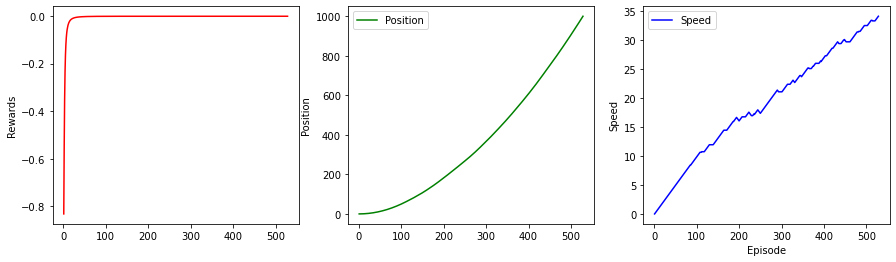

EP: 51	 reward: -3.891	 avg_reward: -5.432	 epsilon: 0.05
EP: 52	 reward: -3.472	 avg_reward: -5.394	 epsilon: 0.05
EP: 53	 reward: -3.434	 avg_reward: -5.357	 epsilon: 0.05
EP: 54	 reward: -3.475	 avg_reward: -5.322	 epsilon: 0.05
EP: 55	 reward: -3.391	 avg_reward: -5.287	 epsilon: 0.05
EP: 56	 reward: -3.396	 avg_reward: -5.253	 epsilon: 0.05
EP: 57	 reward: -3.397	 avg_reward: -5.221	 epsilon: 0.05
EP: 58	 reward: -3.441	 avg_reward: -5.19	 epsilon: 0.05
EP: 59	 reward: -3.424	 avg_reward: -5.16	 epsilon: 0.05
EP: 60	 reward: -3.417	 avg_reward: -5.131	 epsilon: 0.05
EP: 61	 reward: -4.351	 avg_reward: -5.118	 epsilon: 0.05
EP: 62	 reward: -3.474	 avg_reward: -5.092	 epsilon: 0.05
EP: 63	 reward: -3.392	 avg_reward: -5.065	 epsilon: 0.05
EP: 64	 reward: -3.391	 avg_reward: -5.038	 epsilon: 0.05
EP: 65	 reward: -3.493	 avg_reward: -5.015	 epsilon: 0.05
EP: 66	 reward: -3.412	 avg_reward: -4.99	 epsilon: 0.05
EP: 67	 reward: -3.421	 avg_reward: -4.967	 epsilon: 0.05
EP: 68	 reward: -

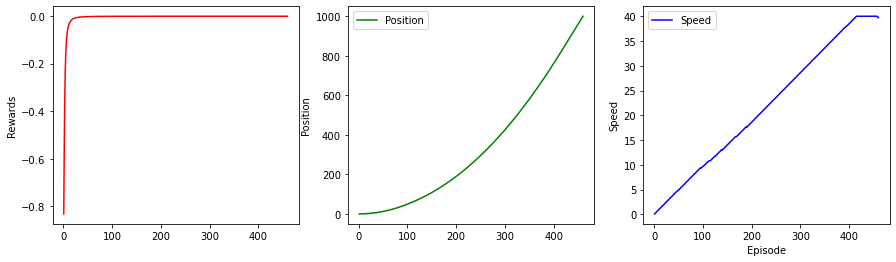

Saving Q_eval network successfully!
Saving Q_target network successfully!
EP: 101	 reward: -3.423	 avg_reward: -3.619	 epsilon: 0.05
EP: 102	 reward: -4.178	 avg_reward: -3.61	 epsilon: 0.05
EP: 103	 reward: -3.436	 avg_reward: -3.607	 epsilon: 0.05
EP: 104	 reward: -3.363	 avg_reward: -3.605	 epsilon: 0.05
EP: 105	 reward: -4.755	 avg_reward: -3.615	 epsilon: 0.05
EP: 106	 reward: -3.411	 avg_reward: -3.613	 epsilon: 0.05
EP: 107	 reward: -3.357	 avg_reward: -3.61	 epsilon: 0.05
EP: 108	 reward: -3.369	 avg_reward: -3.608	 epsilon: 0.05
EP: 109	 reward: -3.759	 avg_reward: -3.611	 epsilon: 0.05
EP: 110	 reward: -3.353	 avg_reward: -3.609	 epsilon: 0.05
EP: 111	 reward: -3.378	 avg_reward: -3.607	 epsilon: 0.05
EP: 112	 reward: -3.348	 avg_reward: -3.606	 epsilon: 0.05
EP: 113	 reward: -3.379	 avg_reward: -3.604	 epsilon: 0.05
EP: 114	 reward: -3.351	 avg_reward: -3.602	 epsilon: 0.05
EP: 115	 reward: -3.549	 avg_reward: -3.599	 epsilon: 0.05
EP: 116	 reward: -3.365	 avg_reward: -3.597

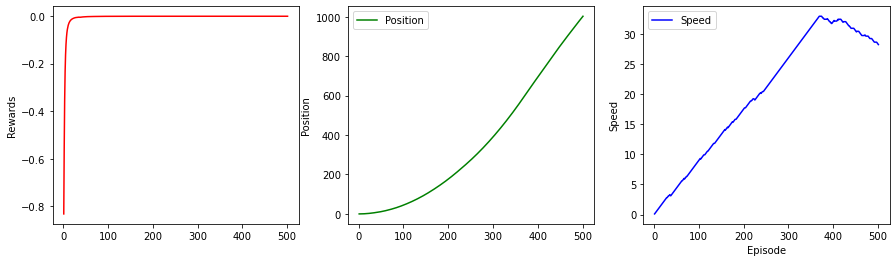

EP: 151	 reward: -4.017	 avg_reward: -3.534	 epsilon: 0.05
EP: 152	 reward: -3.434	 avg_reward: -3.534	 epsilon: 0.05
EP: 153	 reward: -3.391	 avg_reward: -3.534	 epsilon: 0.05
EP: 154	 reward: -3.543	 avg_reward: -3.534	 epsilon: 0.05
EP: 155	 reward: -3.502	 avg_reward: -3.535	 epsilon: 0.05
EP: 156	 reward: -3.467	 avg_reward: -3.536	 epsilon: 0.05
EP: 157	 reward: -4.008	 avg_reward: -3.542	 epsilon: 0.05
EP: 158	 reward: -3.417	 avg_reward: -3.542	 epsilon: 0.05
EP: 159	 reward: -5.341	 avg_reward: -3.561	 epsilon: 0.05
EP: 160	 reward: -4.421	 avg_reward: -3.571	 epsilon: 0.05
EP: 161	 reward: -3.629	 avg_reward: -3.564	 epsilon: 0.05
EP: 162	 reward: -3.599	 avg_reward: -3.565	 epsilon: 0.05
EP: 163	 reward: -4.28	 avg_reward: -3.574	 epsilon: 0.05
EP: 164	 reward: -3.715	 avg_reward: -3.577	 epsilon: 0.05
EP: 165	 reward: -3.708	 avg_reward: -3.58	 epsilon: 0.05
EP: 166	 reward: -4.759	 avg_reward: -3.593	 epsilon: 0.05
EP: 167	 reward: -4.455	 avg_reward: -3.603	 epsilon: 0.05

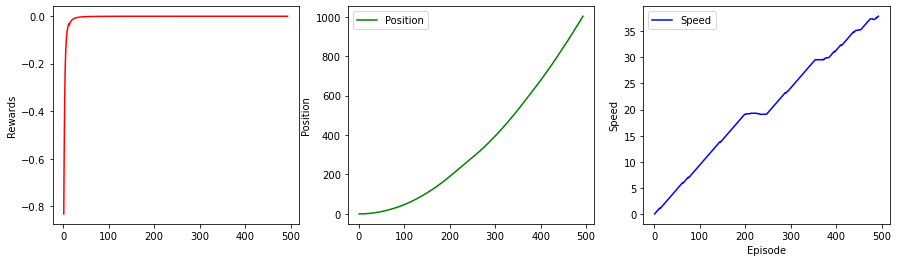

Saving Q_eval network successfully!
Saving Q_target network successfully!


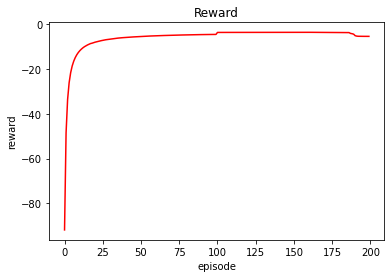

FileNotFoundError: [Errno 2] No such file or directory: './output_images/avg_reward.png'

<Figure size 432x288 with 0 Axes>

In [29]:
import argparse
# from DQN import DQN
# from utils import plot_learning_curve, create_directory

parser = argparse.ArgumentParser()
parser.add_argument('--max_episodes', type=int, default=200)
parser.add_argument('--ckpt_dir', type=str, default='./checkpoints/DQN/')
parser.add_argument('--reward_path', type=str, default='./output_images/avg_reward.png')
parser.add_argument('--epsilon_path', type=str, default='./output_images/epsilon.png')

args, unknown = parser.parse_known_args()


def main():
    env = EcoDrivingEnv()

    agent = DQN(alpha=0.0003, state_dim=env.observation_space.shape[0], action_dim=env.action_space.n,
                fc1_dim=256, fc2_dim=256, ckpt_dir=args.ckpt_dir, gamma=0.99, tau=0.005, epsilon=1.0,
                eps_end=0.05, eps_dec=5e-4, max_size=1000000, batch_size=256)
    
    create_directory(args.ckpt_dir, sub_dirs=['Q_eval', 'Q_target'])
    total_rewards, avg_rewards, eps_history = [], [], []

    for episode in range(args.max_episodes):
        total_reward = 0
        done = False
        observation = env.reset()

        # Record
        states = []
        rewards = []

        while not done:
            action = agent.choose_action(observation, isTrain=True)
            observation_, reward, done, info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            agent.learn()
            total_reward += reward
            observation = observation_

            states.append(observation)
            rewards.append(reward)
            # print(info)
            

        total_rewards.append(total_reward)
        avg_reward = np.mean(total_rewards[-100:])
        avg_rewards.append(avg_reward)
        eps_history.append(agent.epsilon)
        
        print('EP: {}\t reward: {:.4}\t avg_reward: {:.4}\t epsilon: {:.4}'.
              format(episode + 1, total_reward, avg_reward, agent.epsilon))
        
        states = np.array(states)

        if (episode + 1) % 50 == 0:
            visualize_profile(rewards, states)
        


        if (episode + 1) % 100 == 0:
            agent.save_models(episode + 1)

    episodes = [i for i in range(args.max_episodes)]
    plot_learning_curve(episodes, avg_rewards, 'Reward', 'reward', args.reward_path)
    plot_learning_curve(episodes, eps_history, 'Epsilon', 'epsilon', args.epsilon_path)


if __name__ == '__main__':
    main()